In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import json
%matplotlib inline

In [23]:
FOLDER = os.getcwd()
EXP_NAME = "Motor 1 Static"
TARGET_TORQUE = "Torque X"
files = []

for file in os.listdir(FOLDER):
    if file.endswith(".csv"):
        data = pd.read_csv(file)
        target_columns  = []
        for col in data.columns:
            if "Torque" in col: target_columns.append(col)
        data = data[target_columns]

        input = int(file.split("_")[0][1:])/10.0
        files.append([input, data])

In [24]:
x = [file[0] for file in files]
average_torque = [file[1][f"{TARGET_TORQUE} (N-m)"].mean() for file in files]
average_torque_error = [file[1][f"{TARGET_TORQUE} (N-m)"].std() for file in files]

mag_torque = []
mag_torque_error = []
for file in files:
    temp_list = np.array([])
    for vector in file[1].to_numpy():
        temp_list = np.append(temp_list, np.sign(file[0])*np.linalg.norm(vector, np.inf))
    mag_torque.append(temp_list.mean())
    mag_torque_error.append(temp_list.std())

mag_torque = [0.0 if math.isnan(value) else value for value in mag_torque]
mag_torque_error = [0.0 if math.isnan(value) else value for value in mag_torque_error]

points = []
temp_dict = {}

for i in range(len(x)):
    temp_dict[x[i]] = np.array([average_torque[i], average_torque_error[i], mag_torque[i], mag_torque_error[i]]) 

x.sort()

for key in x:
    points.append(np.append(key, temp_dict[key].flatten()))

points = np.array(points).transpose()

values = {
     "input": points[0].tolist(),
     "average_torque": points[1].tolist(),
     "average_torque_error": points[2].tolist(),
     "mag_torque": points[3].tolist(),
     "mag_torque_error": points[4].tolist()
}


with open(os.path.join(FOLDER, 'Values.json'), "w") as file_place:
    json.dump(values, file_place)

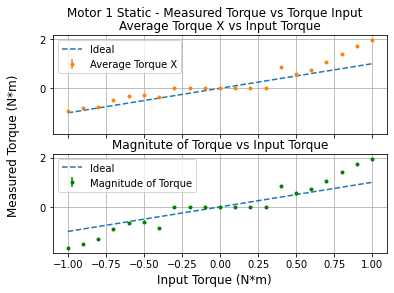

In [25]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)
axs[0].plot(x, points[0], linestyle="dashed", label="Ideal")
axs[0].errorbar(x, points[1], yerr=points[2], fmt="o", markersize="3", label=f"Average {TARGET_TORQUE}")
axs[0].set_title(f"Average {TARGET_TORQUE} vs Input Torque")

axs[1].plot(x, points[0], linestyle="dashed", label="Ideal")
axs[1].errorbar(x, points[3], yerr=points[4], fmt="o", markersize="3", label="Magnitude of Torque", color="green")
axs[1].set_title("Magnitute of Torque vs Input Torque")

title = f"{EXP_NAME} - Measured Torque vs Torque Input"
fig.suptitle(title)
fig.supxlabel("Input Torque (N*m)")
fig.supylabel("Measured Torque (N*m)")

for ax in axs:
    ax.grid()
    ax.legend()

fig.savefig(f'{title}.svg',format='svg',bbox_inches = "tight")
# fig.savefig(f'{title}.png',format='png',bbox_inches = "tight")